# This is the classifier for the butterfly dataset

Below there is the machine learning workflow pipeline

Import packages and device selection

In [1]:
import os
import cv2
import atom
import atom.data_cleaning as dc
import atom.feature_engineering as fe
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device: ", device)

Using device:  cuda


## Dataset preprocessing

In [9]:
data = []
labels = []
path = '../data/images'
folder = os.listdir(path)
for file in folder:
    img = cv2.imread(str(os.path.join(path, file)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    data.append(img)
    labels.append(int(file[:3]) - 1)

label_dict = {0: 'Danaus plexippus',
              1: 'Heliconius charitonius',
              2: 'Heliconius erato',
              3: 'Junonia coenia',
              4: 'Lycaena phlaeas',
              5: 'Nymphalis antiopa',
              6: 'Papilio cresphontes',
              7: 'Pieris rapae',
              8: 'Vanessa atalanta',
              9: 'Vanessa cardui'}
data = np.array(data) / 255.0
labels = np.array(labels)
# categorical_labels = F.one_hot(torch.tensor(labels, requires_grad=False), num_classes=10).numpy()

In [3]:
print([label_dict[labels[i]] for i in range(10)]) 

['Lycaena phlaeas', 'Vanessa cardui', 'Vanessa cardui', 'Junonia coenia', 'Lycaena phlaeas', 'Nymphalis antiopa', 'Papilio cresphontes', 'Danaus plexippus', 'Pieris rapae', 'Nymphalis antiopa']


#### display some samples

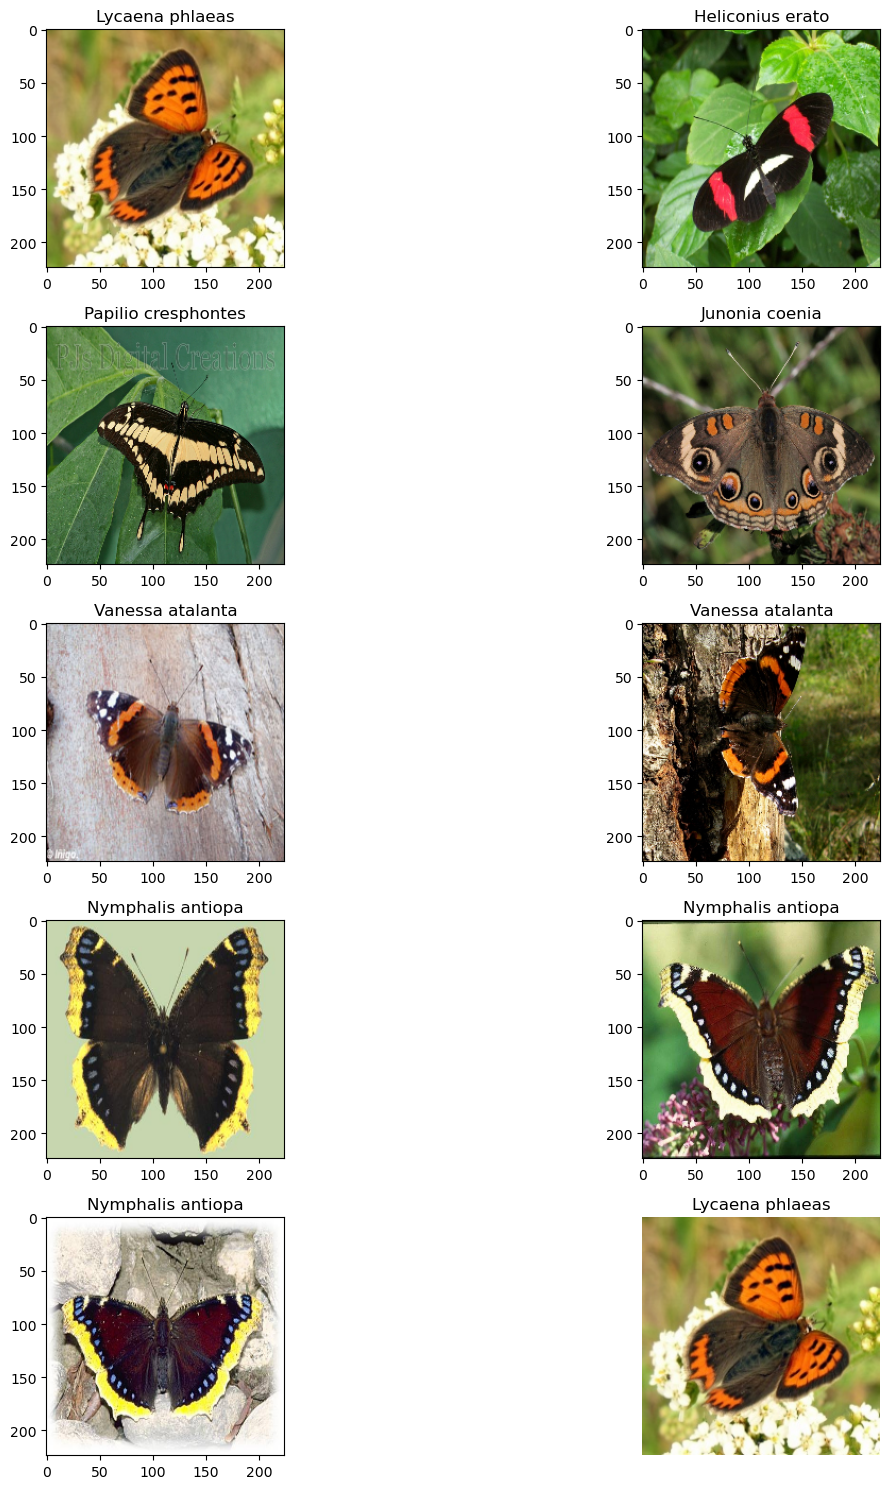

In [4]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=np.random.randint(0,len(labels))
        ax[i,j].imshow(data[l])
        ax[i,j].set_title(str(label_dict[labels[l]]))
plt.axis('off')        
plt.tight_layout()

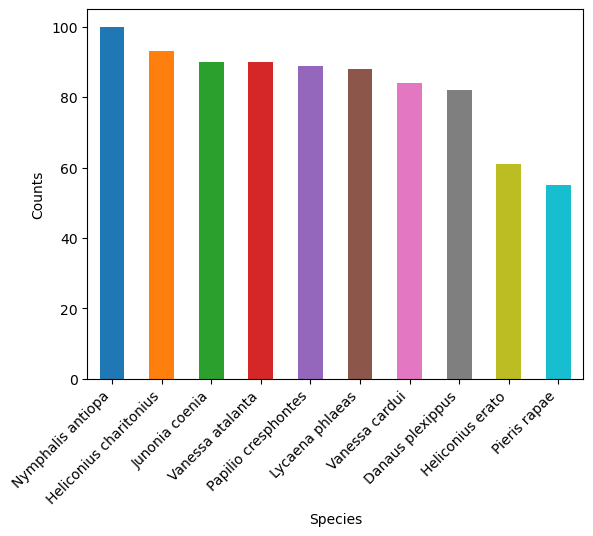

In [5]:
df = pd.DataFrame(labels, columns=['labels'])
df['labels'] = df['labels'].map(label_dict)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [cycle[i % len(cycle)] for i in range(len(df['labels'].unique()))]
df['labels'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Species')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

Flatten data for ingestion to Atom objects

In [11]:
data = data.reshape(len(data), -1)

Use this to revert flatten data to rgb pixels 224x224

## Data cleaning

Use this to check dataset

In [7]:
print(data.shape, labels.shape)
print(data)
print(labels)

(832, 150528) (832,)
[[ 56 133   1 ...  61 118  25]
 [ 87 115 101 ...  37  45  58]
 [ 68 126  85 ... 116 128 124]
 ...
 [ 56  99  43 ...  24  81   2]
 [ 80 153  73 ...  83 137  81]
 [168 179  95 ... 165 183  82]]
[4 9 9 3 4 5 6 0 7 5 1 9 8 6 1 9 3 7 1 9 3 0 3 5 8 5 9 9 7 4 9 5 0 6 6 5 8
 6 4 6 8 3 4 9 6 3 3 9 6 7 2 3 5 8 0 1 0 7 3 7 3 0 2 4 6 4 5 1 6 8 6 8 3 6
 8 4 1 1 9 5 9 0 4 1 1 6 6 4 3 6 9 0 0 2 0 8 5 4 2 9 0 5 6 3 8 0 3 1 5 9 3
 5 0 1 5 9 7 1 7 9 8 2 8 6 5 9 5 3 1 5 5 3 9 9 9 2 7 1 8 8 2 2 2 8 1 9 5 6
 3 8 6 5 1 0 3 5 5 2 1 8 6 4 8 7 3 8 5 0 4 4 6 6 4 9 1 1 8 8 3 0 0 1 0 6 8
 0 3 5 4 0 9 4 1 6 7 1 6 0 9 2 6 5 5 6 3 0 4 9 8 4 8 5 0 3 4 0 5 2 9 0 3 9
 3 0 0 5 4 5 9 7 8 2 3 2 4 0 6 5 4 7 9 8 0 7 3 5 2 5 1 9 6 7 1 4 4 5 9 6 5
 1 5 8 3 3 5 3 8 5 7 2 4 5 1 2 4 0 3 4 8 0 8 4 9 4 2 1 9 4 1 9 9 2 8 4 5 6
 3 4 5 9 3 9 4 6 5 6 1 8 1 5 5 3 4 5 5 3 1 3 5 1 6 7 7 0 8 9 2 8 8 5 9 3 3
 3 8 4 3 8 5 3 6 1 9 0 3 6 9 1 2 7 2 0 0 8 5 0 2 6 4 1 6 9 7 9 5 0 2 1 1 6
 0 7 8 3 0 7 6 0 3 9 8 9 1 3 7 8 5 7 

For a classification task, you can follow these steps in the given order to ensure your data is clean and ready for modeling:

* **Handling Outliers**: Detect and manage outliers in your dataset.
* **Balancing the Data**: Use the Balancer class to address any class imbalance during cross validation.
* **Scaling the Feature Set**: Standardize your dataset to ensure all features are on a similar scale.

This sequence helps in systematically preparing your data for a classification model.

In [12]:
data, labels = (dc.Pruner(strategy=['lof', 'iforest'],
                   device='cpu',
                   engine='sklearn',
                   verbose=2,
                   iforest={'contamination': 'auto', 'bootstrap': True, 'n_jobs': -1, 'random_state': 1},
                   lof={'n_neighbors': 20, 'contamination': 'auto', 'n_jobs': -1}
                   )
          .fit_transform(data, labels))

Fitting Pruner...
Pruning outliers...
 --> The LocalOutlierFactor detected 13 outliers.
 --> The IsolationForest detected 277 outliers.
 --> Dropping 13 outliers.


In [ ]:
data = data.reshape(len(data), 224, 224, 3)
cat_labels = F.one_hot(torch.tensor(labels, requires_grad=False), num_classes=10).numpy()